In [36]:
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import sys
import copy
from scipy.stats import mannwhitneyu

PARENT_DIR = '/home/groups/dpwall/briannac/blood_microbiome/'
bam_mappings_file  = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'
fig_dir = PARENT_DIR + 'results/unmapped_read_distribution/'
# Input files
virus_file = PARENT_DIR + 'data/virus_no_agg.csv'
bacteria_no_agg_file = PARENT_DIR + 'data/bacteria_no_agg.csv'
bacteria_agg_strain_file = PARENT_DIR + 'data/bacteria_agg_strain.csv'
bacteria_agg_species_file = PARENT_DIR + 'data/bacteria_agg_species.csv'
unmapped_file = PARENT_DIR + 'data/unmapped.tsv'
ihart_flagstat_file = PARENT_DIR + 'data/ihart_flagstat.csv'
#virus_chloe_file = PARENT_DIR + 'data/virus_chloe_pipeline.csv'
#bacteria_chloe_file = PARENT_DIR + 'data/bacteria_chloe_pipeline.csv'


alt_hap_file = PARENT_DIR + 'data/alt_hap_no_agg.csv'

# Output files
bacteria_filtered_file = PARENT_DIR + 'data/bacteria_filtered.csv'
virus_filtered_file = PARENT_DIR + 'data/virus_filtered.csv'


#sys.path.append('/home/groups/dpwall/briannac/blood_microbiome/src')

sns.set_palette('husl')

In [43]:
bam = pd.read_csv(bam_mappings_file, sep='\t')
bam[['sex_numeric', 'family', 'derived_affected_status', 'sequencing_plate', 'bio_seq_source', 'relationship']][bam['sequencing_plate']=='MTR-00927']

,sex_numeric,family,derived_affected_status,sequencing_plate,bio_seq_source,relationship
0,1.0,AU1005,NaN,MTR-00927,LCL,father
1,2.0,AU1005,NaN,MTR-00927,LCL,mother
2,2.0,AU1005,broad-spectrum,MTR-00927,LCL,sibling
3,1.0,AU1005,autism,MTR-00927,LCL,sibling
144,2.0,AU0974,NaN,MTR-00927,LCL,mother
...,...,...,...,...,...,...
2383,1.0,AU1227,autism,MTR-00927,LCL,sibling
2389,2.0,AU1227,NaN,MTR-00927,LCL,mother
2466,2.0,AU1271,NaN,MTR-00927,LCL,mother
2467,2.0,AU1271,autism,MTR-00927,LCL,sibling


In [4]:
bam_mappings = pd.read_csv(bam_mappings_file, sep='\t', index_col=1)

In [8]:
### Read in files:
#bacteria_no_agg = pd.read_csv(bacteria_no_agg_file, index_col=0)
bacteria_agg_strain = pd.read_csv(bacteria_agg_strain_file, index_col=0)
bacteria_agg_species = pd.read_csv(bacteria_agg_species_file, index_col=0)
virus = pd.read_csv(virus_file, index_col=0)
alt_hap = pd.read_csv(alt_hap_file, index_col=0)
unmapped = pd.read_csv(unmapped_file, index_col=0, sep=' ', header=None)
unmapped.columns = ['ultimately unmapped']
ihart_flagstat = pd.read_csv(ihart_flagstat_file, index_col=0)

In [9]:
total_to_realign = pd.DataFrame(bacteria_agg_strain.sum(axis=1) + virus.sum(axis=1) + alt_hap.sum(axis=1) + unmapped['ultimately unmapped'],
                                columns=['total to realign'])
y_chrom_contigs = ['Fusobacterium ulcerans', 'Mollicutes bacterium D7']
contaminant_contigs = ['Enterobacteria phage phiX174', 'Human herpesvirus 4']
y_chrom = pd.DataFrame(bacteria_agg_strain[y_chrom_contigs].sum(axis=1), columns=['y-chrom'])
contaminants = pd.DataFrame(virus[contaminant_contigs].sum(axis=1), columns=['contaminants'])
bacteria_agg_strain = bacteria_agg_strain.drop(y_chrom_contigs, axis=1)
virus = virus.drop(contaminant_contigs, axis=1)
initially_unmapped = pd.DataFrame(ihart_flagstat['Total_Reads'] - ihart_flagstat['Mapped'], columns=['initially_unmapped'])
total_reads = pd.DataFrame(ihart_flagstat['Total_Reads'] - ihart_flagstat['Supplementary'] - ihart_flagstat['Duplicates'], columns=['total reads'])

In [10]:
bacteria_well_aligned = pd.DataFrame(bacteria_agg_strain.sum(axis=1)-bacteria_agg_strain['ambig']-bacteria_agg_strain['poorly_aligned'],
                                     columns=['bacteria_well_aligned'])
virus_well_aligned = pd.DataFrame(virus.sum(axis=1)-virus['ambig']-virus['poorly_aligned'],
                                     columns=['virus_well_aligned'])
alt_hap_well_aligned = pd.DataFrame(alt_hap.sum(axis=1)-alt_hap['ambig']-alt_hap['poorly_aligned'],
                                     columns=['alt_hap_well_aligned'])
read_distribution = bacteria_well_aligned.join(virus_well_aligned).join(alt_hap_well_aligned).join(unmapped['ultimately unmapped']).join(
    bacteria_agg_strain['ambig'], rsuffix='_bacteria').join(virus['ambig'], rsuffix='_virus').join(alt_hap['ambig'], rsuffix='_alt_hap').join(
    bacteria_agg_strain['poorly_aligned'], rsuffix='_bacteria').join(virus['poorly_aligned'], rsuffix='_virus').join(alt_hap['poorly_aligned'], rsuffix='_alt_hap').join(
    y_chrom).join(contaminants).join(initially_unmapped).join(total_reads).join(total_to_realign)
cols = np.array(read_distribution.columns)
cols[cols=='ambig'] = 'ambig_bacteria'
cols[cols=='poorly_aligned'] = 'poorly_aligned_bacteria'
read_distribution.columns = cols
read_distribution['microbe'] = read_distribution['bacteria_well_aligned'] + read_distribution['ambig_bacteria']
read_distribution['virus'] = read_distribution['virus_well_aligned'] + read_distribution['ambig_virus']
read_distribution['alt hap'] = read_distribution['alt_hap_well_aligned'] + read_distribution['ambig_alt_hap']
read_distribution['poorly aligned'] = read_distribution[['poorly_aligned_virus', 'poorly_aligned_bacteria', 'poorly_aligned_alt_hap']].sum(axis=1)

In [11]:
print('initially unmapped/total to realign', 
      np.nanmedian(read_distribution['initially_unmapped']/read_distribution['total to realign']))
print('unmapped', 'initially unmapped',
      np.nanmedian(read_distribution['ultimately unmapped']/read_distribution['initially_unmapped']))
print('ambig virus/all virus',
      np.nanmedian(read_distribution['ambig_virus']/read_distribution[['virus_well_aligned', 'ambig_virus', 'contaminants']].sum(axis=1)))
print('ambig bacteria/all bacteria', 
      np.nanmedian(read_distribution['ambig_bacteria']/read_distribution[['bacteria_well_aligned', 'ambig_bacteria', 'y-chrom']].sum(axis=1)))
print('ambig alt hap/all alt hap',
      np.nanmedian(read_distribution['ambig_alt_hap']/read_distribution[['alt_hap_well_aligned', 'ambig_alt_hap']].sum(axis=1)))

initially unmapped/total to realign 0.509422666039042
unmapped initially unmapped 0.582597947815785
ambig virus/all virus 0.0002832707592652222
ambig bacteria/all bacteria 0.3763272222522669
ambig alt hap/all alt hap 0.09857349769196302


In [15]:
#read_distribution = read_distribution[['total reads', 'total to realign','contaminants','y-chrom','microbe', 'virus', 'alt hap', 'poorly aligned', 'ultimately unmapped']]
read_distribution['sample'] = read_distribution.index

# Distribution of dataset

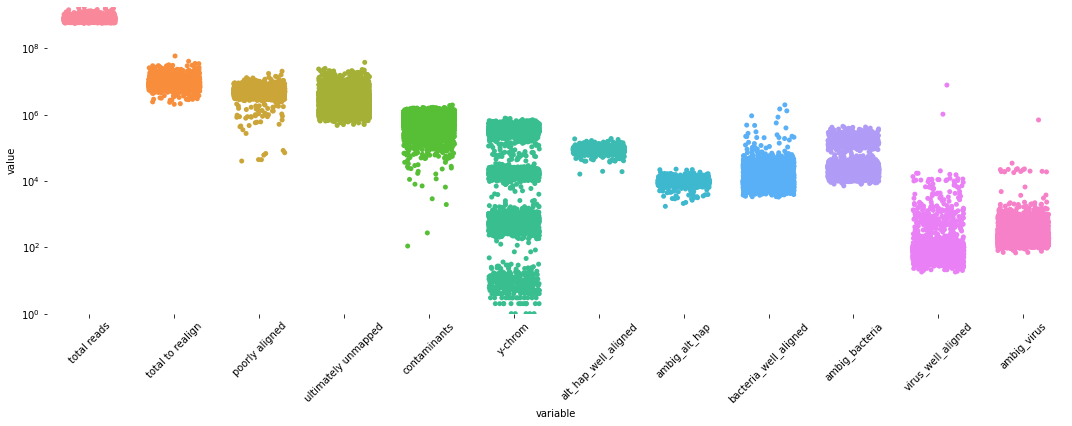

In [35]:
df_melt = read_distribution.melt(id_vars='sample')
plt.figure(figsize=(15,5))
ax = sns.stripplot(data=df_melt,  x='variable', y='value', jitter=.3, order=['total reads','total to realign', 'poorly aligned', 'ultimately unmapped', 'contaminants', 'y-chrom',
                                                                             'alt_hap_well_aligned', 'ambig_alt_hap',
                                                                             'bacteria_well_aligned', 'ambig_bacteria',
                                                                             'virus_well_aligned', 'ambig_virus'])
plt.yscale('log')
plt.box(on=False)
plt.ylim(1,read_distribution['total reads'].max())
plt.tight_layout()
plt.xticks(rotation=45) 
plt.savefig(fig_dir + 'read_dist.png', 
            transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

In [30]:
read_distribution.drop('sample', axis=1).apply(np.nanmedian)

bacteria_well_aligned           9344.0
virus_well_aligned                83.0
alt_hap_well_aligned           86415.0
ultimately unmapped          2190589.0
ambig_bacteria                 23098.0
ambig_virus                      203.0
ambig_alt_hap                   9417.0
poorly_aligned_bacteria       296210.0
poorly_aligned_virus           15495.0
poorly_aligned_alt_hap       4253553.0
y-chrom                        22333.0
contaminants                  725117.0
initially_unmapped           4047285.0
total reads                762009524.0
total to realign             8247489.0
microbe                        32670.0
virus                            287.0
alt hap                        95783.0
poorly aligned               4787214.0
dtype: float64

In [31]:
read_distribution_frac = read_distribution.drop(['sample'], axis=1).apply(lambda x: x/read_distribution['total to realign'])
read_distribution_frac['sample'] = read_distribution_frac.index
read_distribution_frac['total to realign'] = read_distribution['total to realign']/read_distribution['total reads']

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  """


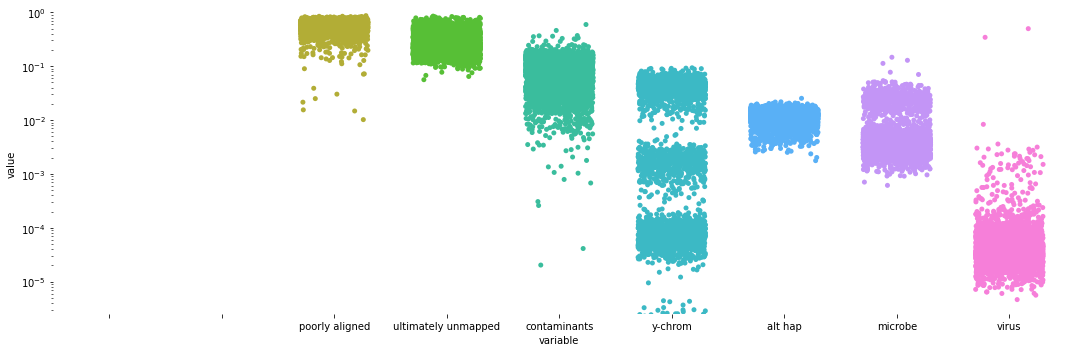

In [19]:
df_melt = read_distribution_frac.melt(id_vars='sample')
plt.figure(figsize=(15,5))
ax = sns.stripplot(data=df_melt,  x='variable', y='value', jitter=.3, order=[' ',' ', 'poorly aligned', 'ultimately unmapped', 'contaminants', 'y-chrom', 'alt hap','microbe', 'virus'])
plt.yscale('log')
plt.ylim(df_melt['value'].min(),1)
plt.box(on=False)
plt.tight_layout()
plt.savefig(fig_dir + 'read_dist_frac.png', 
            transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

In [12]:
for col, i, j, k in zip(read_distribution.columns[:-1],read_distribution.drop('sample', axis=1).apply(np.nanmedian), read_distribution.drop('sample', axis=1).apply(np.max), read_distribution.drop('sample', axis=1).apply(np.min)):
    print(col, i,j,k)

print('\n\nfrac')
    
for col, i, j, k in zip(read_distribution_frac.columns[:-1],read_distribution_frac.drop('sample', axis=1).apply(np.nanmedian), read_distribution_frac.drop('sample', axis=1).apply(np.max), read_distribution_frac.drop('sample', axis=1).apply(np.min)):
    print(col, i,j,k)

bacteria_well_aligned 4987.0 1716581.0 1462.0
virus_well_aligned 54.0 7747837.0 6.0
alt_hap_well_aligned 85280.0 186771.0 15758.0
ultimately unmapped 2190061.5 37480211.0 471088.0
ambig_bacteria 40827.0 523434.0 8486.0
ambig_virus 232.0 714139.0 75.0
ambig_alt_hap 10616.0 25543.0 2046.0
poorly_aligned_bacteria 296988.0 8921216.0 13416.0
poorly_aligned_virus 15497.5 5733950.0 3549.0
poorly_aligned_alt_hap 4254367.0 10072036.0 12259.0
y-chrom 21851.5 754364.0 0.0
contaminants 724861.0 1941807.0 109.0
initially_unmapped 4047277.0 42341791.0 848451.0
total reads 762001564.0 1732651625.0 557634550.0
total to realign 8254776.0 58417663.0 2049805.0
microbe 46485.5 2240015.0 10398.0
virus 288.0 8461976.0 96.0
alt hap 95865.0 211237.0 17804.0
poorly aligned 4776287.0 20259786.0 39847.0


frac
bacteria_well_aligned 0.0006088372628613655 0.11358275852075314 9.212578288427849e-05
virus_well_aligned 6.556610430114653e-06 0.4550736849573956 3.6190332922713796e-07
alt_hap_well_aligned 0.0104279894501

# Dataset demographics

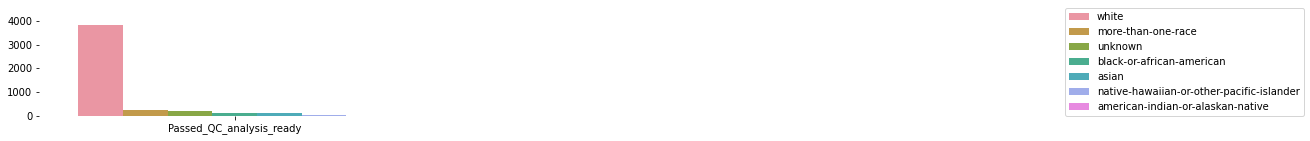

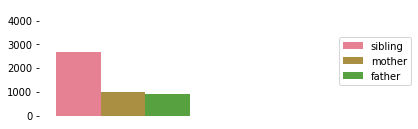

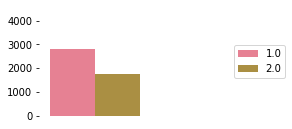

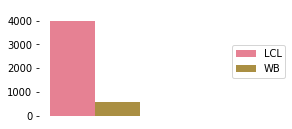

In [13]:
bam_mappings = pd.read_csv('/home/groups/dpwall/briannac/general_data/bam_mappings.csv', sep='\t', index_col=1)
bam_mappings = bam_mappings[bam_mappings['status']=='Passed_QC_analysis_ready']
bam_mappings['batch'] = [str(i).replace('MTR-','batch_').replace('_LCL', '-LCL') for i in bam_mappings.sequencing_plate.values]
#bam_mappings['batch'].to_csv('/home/groups/dpwall/briannac/general_data/sample_and_batches.csv', sep='\t', header=None)


plt.figure(figsize=(7,2))
g = sns.countplot(data=bam_mappings, hue='race', x='status',hue_order=[
    'white', 'more-than-one-race', 'unknown', 'black-or-african-american', 
    'asian', 'native-hawaiian-or-other-pacific-islander', 'american-indian-or-alaskan-native' 
    ])
g.legend(loc='center right', bbox_to_anchor=(3.25, 0.5), ncol=1)
plt.ylim(0,len(bam_mappings))
plt.box(on=False)
plt.xlabel('')
plt.ylabel('')
plt.savefig(fig_dir + 'race.png', 
            transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

plt.figure(figsize=(3,2))
g = sns.countplot(data=bam_mappings, hue='relationship', x='status', hue_order=['sibling', 'mother', 'father'])
g.legend(loc='center right', bbox_to_anchor=(2.25, 0.5), ncol=1)
plt.ylim(0,len(bam_mappings))
plt.box(on=False)
plt.xlabel('')
plt.ylabel('')
plt.xticks([1],[''])
plt.savefig(fig_dir + 'relationship.png', 
            transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

plt.figure(figsize=(2,2))
g = sns.countplot(data=bam_mappings, hue='sex_numeric', x='status', hue_order=['1.0', '2.0'])
g.legend(loc='center right', bbox_to_anchor=(2.25, 0.5), ncol=1)
plt.ylim(0,len(bam_mappings))
plt.box(on=False)
plt.xlabel('')
plt.ylabel('')
plt.xticks([1],[''])
plt.savefig(fig_dir + 'sex.png', 
            transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

plt.figure(figsize=(2,2))
g = sns.countplot(data=bam_mappings, hue='bio_seq_source', x='status', )
g.legend(loc='center right', bbox_to_anchor=(2.25, 0.5), ncol=1)
plt.ylim(0,len(bam_mappings))
plt.box(on=False)
plt.xlabel('')
plt.ylabel('')
plt.xticks([1],[''])
plt.savefig(fig_dir + 'cell_type.png', 
            transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

## Differences in loads

In [14]:
# ASD vs NT on microbial loads
asd = set(bam_mappings[(bam_mappings['relationship']=='sibling') & (bam_mappings['derived_affected_status']=='autism')].index).intersection(read_distribution.index)
nt = set(bam_mappings[(bam_mappings['relationship']=='sibling') & (pd.isna(bam_mappings['derived_affected_status']))].index).intersection(read_distribution.index)
males = set(bam_mappings[bam_mappings['sex_numeric']=='1.0'].index).intersection(read_distribution.index)
females = set(bam_mappings[bam_mappings['sex_numeric']=='2.0'].index).intersection(read_distribution.index)

#read_distribution.loc[sibs[sibs.sex_numeric=='1.0'].index]

In [15]:
for c in ['bacteria_well_aligned', 'virus_well_aligned', 'alt_hap_well_aligned',
       'ultimately unmapped', 'y-chrom', 'contaminants', 'ultimately unmapped']:
    p = mannwhitneyu(read_distribution[c].loc[asd], read_distribution[c].loc[nt], alternative='less').pvalue
    if (p<.05):
        print(c,p, 'nt more')
    p = mannwhitneyu(read_distribution[c].loc[asd], read_distribution[c].loc[nt], alternative='greater').pvalue
    if (p<.05):
        print(c,p, 'asd more')

        


y-chrom 2.962836363165915e-25 asd more


In [16]:
for c in ['bacteria_well_aligned', 'virus_well_aligned', 'alt_hap_well_aligned',
       'ultimately unmapped', 'y-chrom', 'contaminants', 'ultimately unmapped']:
    p = mannwhitneyu(read_distribution[c].loc[males], read_distribution[c].loc[females], alternative='less').pvalue
    if (p<.05):
        print(c,p, 'females more')
    p = mannwhitneyu(read_distribution[c].loc[males], read_distribution[c].loc[females], alternative='greater').pvalue
    if (p<.05):
        print(c,p, 'males more')

alt_hap_well_aligned 0.0009053587915397931 males more
y-chrom 0.0 males more
contaminants 4.9310372487697086e-15 males more


# Filtering

312 0.2504012841091493


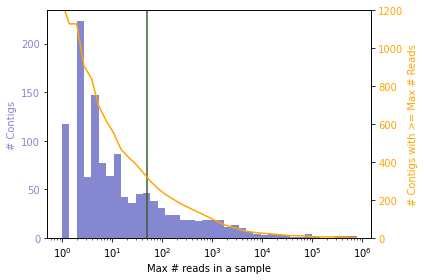

47 0.23618090452261306


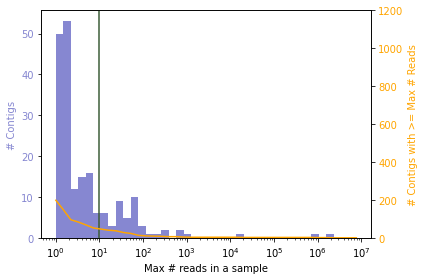

In [26]:
bacteria_agg_strain = pd.read_csv(bacteria_agg_strain_file, index_col=0)
virus = pd.read_csv(virus_file, index_col=0)
bacteria_filt = bacteria_agg_strain.drop(['poorly_aligned', 'ambig'], axis=1)
virus_filt = virus.drop(['poorly_aligned', 'ambig'], axis=1)

def contig_counts(data, N):
    hist, bins = np.histogram(data.max(), bins=40)
    fig, ax1 = plt.subplots()
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    ax1.hist(data.max(), bins=logbins, color='#8687d1')
    ax1.set_xscale('log')
    ax1.set_xlabel('Max # reads in a sample')
    ax1.set_ylabel('# Contigs', color='#8687d1')
    ax1.tick_params(axis='y', labelcolor='#8687d1')
    ax1.set_xscale('log')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('# Contigs with >= Max # Reads', color='orange')  # we already handled the x-label with ax1
    ax2.plot(logbins,[sum(data.max()>=n) for n in logbins], color='orange')
    print(sum(data.max()>N), np.mean(data.max()>N))
    ax2.tick_params(axis='y', labelcolor='orange')
    ax1.set_xscale('log')
    ax2.set_ylim(0,1200)
    ax2.vlines(x=N, ymin=0, ymax=1200, color='#3b5c36')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
contig_counts(bacteria_filt, 50)
contig_counts(virus_filt, 10)

In [27]:
print((virus_filt==0).mean().mean(), 'virus sparsity')
print(np.shape(virus_filt))
print((bacteria_filt==0).mean().mean(), 'bacteria sparsity')
print(np.shape(bacteria_filt))
virus_filt = virus_filt[virus_filt.columns[virus_filt.max()>10]]
print(np.shape(virus_filt))
bacteria_filt = bacteria_filt[bacteria_filt.columns[bacteria_filt.max()>50]]
print(np.shape(bacteria_filt))

print((virus_filt==0).mean().mean(), 'virus sparsity')
print((bacteria_filt==0).mean().mean(), 'bacteria sparsity')

0.9476493481200617 virus sparsity
(4567, 199)
0.9065901623096252 bacteria sparsity
(4567, 1246)
(4567, 47)
(4567, 312)
0.8110217145199836 virus sparsity
0.7341512129939982 bacteria sparsity


In [28]:
virus_filt.to_csv(virus_filtered_file)
bacteria_filt.to_csv(bacteria_filtered_file)